In [1]:
import numpy as np
from itertools import combinations, product
from queue import PriorityQueue

import matplotlib.pyplot as plt

from tsp_util import *
from tsp_estimator import predict_tsp_supported
from mhp_qaoa import MHP_QAOA

In [2]:
def tsp_astar(positions, adj_matrix, steps, prediction_error_margin=0.99, classical_solver=True):
    
    def construct_subproblem(start_node, node_set, last_node):
        nodes = (start_node, *node_set, last_node)
        
        node_mapping = {i:x for i,x in enumerate(nodes)}
        
        sub_positions = positions[nodes, :]
        sub_adj_matrix = adj_matrix[nodes,:][:,nodes]
            
        return sub_positions, sub_adj_matrix, node_mapping
    
    def translate_subsolution(path, mapping):
        return tuple(mapping[i] for i in path)
    
    def predict_subproblem_large(start_node, node_set, support_set):
        if prediction_error_margin == 0:
            return 0
        
        sub_positions, sub_adj_matrix, node_mapping = construct_subproblem(start_node, node_set, 0)
        node_mapping_reverse = {v: k for k, v in node_mapping.items()}
        support_set_new = frozenset(node_mapping_reverse[i] for i in support_set)
        start_node_new = node_mapping_reverse[start_node]
        
        # Insert TSP tour length predictor here, multiply with prediction_error_margin
        return predict_tsp_supported(sub_positions, sub_adj_matrix, tuple(support_set_new), start_node_new)*prediction_error_margin
    
    def predict_subproblem_small(start_node, node_set, last_node):
        if prediction_error_margin == 0:
            return 0
        
        if (start_node, node_set, last_node) in predictions:
            return predictions[(start_node, node_set, last_node)]
        
        # Very small instances are difficult to estimate but easy to solve,
        # hence we just solve them here for the estimation
        _, sub_adj_matrix, node_mapping = construct_subproblem(start_node, node_set.difference((last_node,)), last_node)
        _, distance = tsp_dynamic(sub_adj_matrix, first_node=0, last_node=steps)
        predictions[(start_node, node_set, last_node)] = distance*prediction_error_margin
        
        return distance*prediction_error_margin
        
    def solve_subproblem(start_node, node_set, last_node):
        if (start_node, node_set, last_node) in solutions:
            return solutions[(start_node, node_set, last_node)]
        
        _, sub_adj_matrix, node_mapping = construct_subproblem(start_node, node_set.difference((last_node,)), last_node)
        # Insert TSP solver here
        # The TSP solver should be able to adapt the first and final node visited independently
        if classical_solver:
            path, distance = tsp_dynamic(sub_adj_matrix, first_node=0, last_node=steps)
        else:
            path, distance = tsp_qaoa_solver.solve(sub_adj_matrix, p=1, start_node=0, goal_node=steps)
        
        path = translate_subsolution(path, node_mapping)
        
        solutions[(start_node, node_set, last_node)] = (path, distance)
        return path, distance
    
    def candidates_step(node_set, size):
        return (nearest_neighbours[i][np.isin(nearest_neighbours[i], tuple(node_set), assume_unique=True)][:size] for i in node_set)
    
    n = len(positions)
        
    # Recall already computed solutions
    solutions = {}
    predictions = {}
    
    init_minimum = np.sum(adj_matrix)
    nodes = frozenset(range(1, n))
    node_queue = PriorityQueue()
    
    if not classical_solver:
        tsp_qaoa_solver = MHP_QAOA(steps-1, 1)
        tsp_qaoa_solver.build_circuit()
    
    # Get nearest neighbours for each node
    nearest_neighbours = {}
    for index, row in enumerate(adj_matrix):
        nearest_neighbours[index] = np.argsort(row)
                
    for support_nodes in combinations(nodes, n//steps):
        support_set = frozenset(support_nodes)
        prediction = predict_tsp_supported(positions, adj_matrix, tuple(support_set))*prediction_error_margin
        node_queue.put((prediction, 
                        (0, 0, frozenset(), (), 0, support_set, frozenset())))

    counter = 0
    while not node_queue.empty():
        # Values in NodeQueue are a tuple containing the following:
        # 1. Start Node of the next subproblem
        # 2. End Node of the next subproblem
        # 3. All nodes already visited
        # 4. Optimum path so far
        # 5. Optimum distance so far
        # 6. The remaining support nodes
        # 7. The set of nodes to be used to get from 1. to 2.
        expansion = node_queue.get()[1]
        start_node = expansion[0]
        next_node = expansion[1]
        visited_nodes = expansion[2]
        current_path = expansion[3]
        current_distance = expansion[4]
        support_set = expansion[5]
        target_set = expansion[6]
        
        # There is no target set in this case
        if start_node == 0 and next_node == 0:
            new_path = ()
            new_distance = 0
            new_visited = frozenset()
        else:
            # Final node reached, terminate
            if next_node == 0:
                return current_path + (0, ), current_distance + adj_matrix[start_node, 0], counter

            # Else, take a step towards the goal
            (path, distance) = solve_subproblem(start_node, target_set, next_node)
            counter += 1
            new_path = current_path + tuple(path)
            new_distance = current_distance + distance
            new_visited = frozenset(new_path)
            
        if new_visited == nodes:
            # In this case only the step to the start remains
            node_queue.put((new_distance + adj_matrix[next_node, 0], 
                           (next_node, 0, new_visited, new_path, new_distance, frozenset(), frozenset())))
        else:
            for new_next in support_set:
                for node_combination in candidates_step(nodes.difference(new_visited).difference(support_set.difference((new_next,))), steps):
                    if new_next in node_combination:
                        step_set = frozenset(node_combination)
                        rest_set = nodes.difference(step_set).difference(new_visited)
                        prediction_step = predict_subproblem_small(next_node, step_set, new_next)
                        if len(rest_set) < 1:
                            prediction_rest = adj_matrix[new_next, 0]
                        elif len(rest_set) == steps:
                            prediction_rest = predict_subproblem_small(new_next, rest_set, 0)
                        else:
                            prediction_rest = predict_subproblem_large(new_next, rest_set, support_set.difference((new_next,)))
                        predicted_distance = prediction_step + prediction_rest
                        node_queue.put((new_distance+predicted_distance, 
                                       (next_node, new_next, new_visited, new_path, new_distance, support_set.difference((new_next,)), step_set)))

In [3]:
class TSPVisualization:
    def __init__(self):
        self.instance = None
        self.adj_matrix = None
        self.solutions = []
        
    def generate_instance(self, size, return_adj_matrix=True):
        self.instance, adj_matrix = generate_tsp_instance(size)
        if return_adj_matrix:
            return adj_matrix
    
    def set_instance(self, instance):
        self.instance = instance
    
    def get_instance(self):
        return self.instance
        
    def add_solution(self, path, color="orange", line_width=5):
        self.solutions.append((path, color, line_width))
    
    def draw_solution(self, 
                      full_graph=False, 
                      full_graph_color="black",
                      full_graph_alpha=0.3,
                      full_graph_width=2,
                      xlim=(-11, 11), 
                      ylim=(-11, 11), 
                      figsize=(12, 12), 
                      dot_size=120):
        figure = plt.figure(figsize=figsize)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.scatter([x for x, _ in self.instance], [y for _, y in self.instance], color="black", s=dot_size)

        if full_graph:
            for p1, p2 in product(self.instance, self.instance):
                if not np.array_equal(p1, p2):
                    plt.plot((p1[0], p2[0]), (p1[1], p2[1]), color=full_graph_color, alpha=full_graph_alpha, linewidth=full_graph_width)
        
        for path, color, line_width in self.solutions:
            for p1, p2 in zip(path[:-1], path[1:]):
                plt.plot((self.instance[p1][0], self.instance[p2][0]), (self.instance[p1][1], self.instance[p2][1]), 
                         color=color, linewidth=line_width)
        
        plt.axis("off")
        plt.close(figure)
        return figure

In [4]:
nodes, edges = generate_tsp_instance(17)

In [5]:
vis = TSPVisualization()
vis.set_instance(nodes)

In [6]:
# Set classical_solver = True to solve the subinstances using dynamic programming
# Set classical_solver = False to solve the subinstances using QAOA
approx, dist1, n_subproblems = tsp_astar(nodes, edges, steps=4, prediction_error_margin=0.99, classical_solver=True)
# Solution does not include the first node, but is required for visualization
approx = (0,)+approx
print("Traveled distance using A* subdivision algorithm: {}\nNumber of Subproblems solved: {}".format(dist1, n_subproblems))

Traveled distance using A* subdivision algorithm: 84.8826285416106
Number of Subproblems solved: 2646


In [7]:
optimum, dist2 = tsp_dynamic(edges)
# Solution does not include the first node, but is required for visualization
optimum = (0,)+optimum
print("Optimum tour length for the given problem: {}".format(dist2))

Optimum tour length for the given problem: 77.56443679314745


## Optimum solution

In [8]:
vis.add_solution((0,)+optimum)

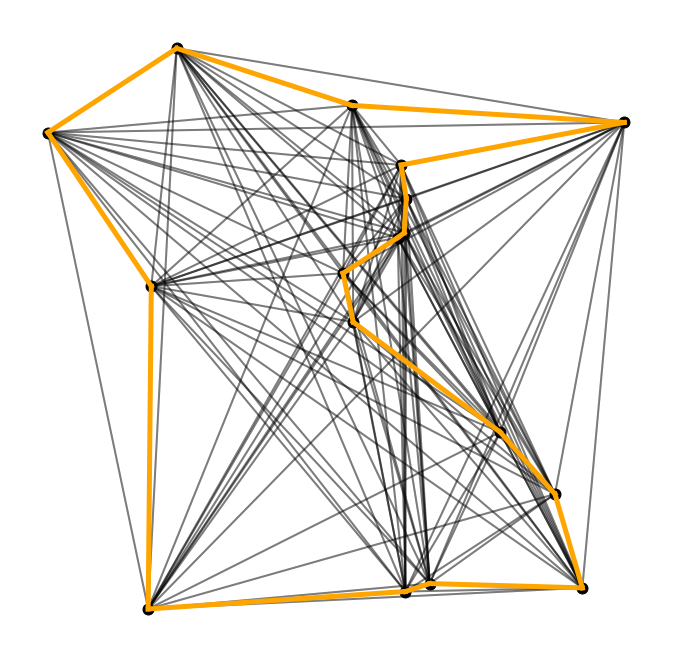

In [9]:
figure = vis.draw_solution(full_graph=True)
figure

## Approximation with subtours

In [10]:
vis = TSPVisualization()
vis.set_instance(nodes)

In [11]:
vis.add_solution(approx[:5], color="purple")
vis.add_solution(approx[4:9], color="red")
vis.add_solution(approx[8:13], color="green")
vis.add_solution(approx[12:], color="cyan")

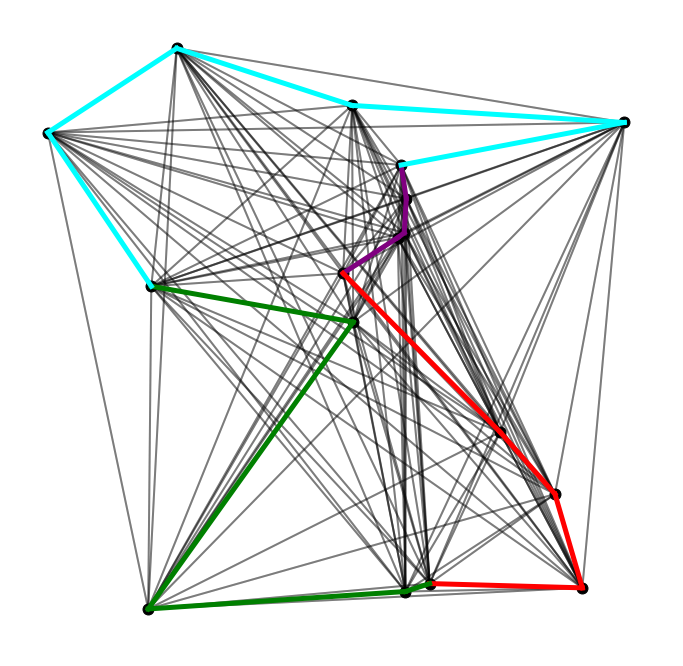

In [12]:
figure = vis.draw_solution(full_graph=True)
figure